# The impact of randomness

We know that SIR is a stochastic process (as are other epidemic models). What does this mean in practice for data collection and analysis? In this notebook we'll re-visit the experiment we did earlier that collected detailed experimental observations of SIR around its epidemic threshold &ndash; but we'll look at thjis through the lens of *expecting* to see statistical noise. Then we'll see how to manage this noise.

In [1]:
# maths support
import numpy

# data handling
import pandas
from pathlib import Path
datasets = Path("../../datasets")
datasets.mkdir(parents=True, exist_ok=True)

# simulation
from epyc import Experiment, ParallelLab, JSONLabNotebook
from epydemic import ERNetwork, SIR, StochasticDynamics

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

## The underlying data

Let's begin by loading and re-plotting our previous experiment.

In [2]:
# load our previous notebook
nb_sir = JSONLabNotebook(Path(datasets, "09-06-sir.json"))

# check we've done the experiment we need
if "sir_er_verylow" not in nb_sir.resultSets():
    raise Exception("Need to run the 'sir_er_verylow' experiment first")

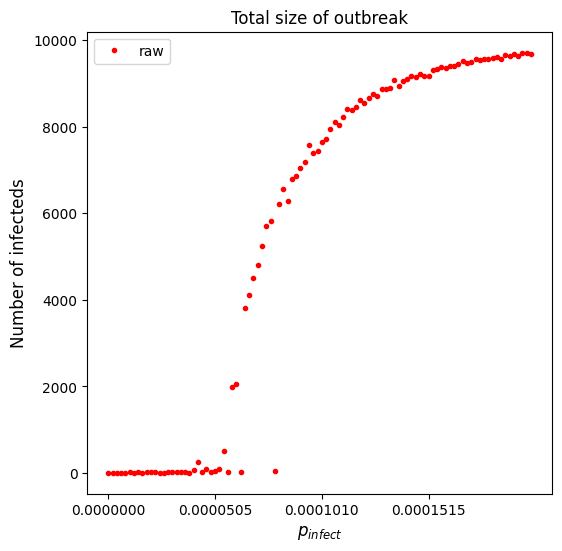

In [3]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb_sir.dataframe("sir_er_verylow")
ax.plot(df[SIR.P_INFECT], df[SIR.REMOVED], 'r.', label="raw")

# fill in the title and axis labels
ax.set_title('Total size of outbreak')
ax.set_xlabel('$p_{infect}$')
pInfects = numpy.linspace(0.0, 0.0002, num=100)
ax.set_xticks(pInfects[::25])                  # only label some selected points
ax.set_ylabel('Number of infecteds')
ax.legend(loc='upper left')
plt.show()

We can see that there is a clear transition from no outbreak to a full epidemic. But the curve &ndash; made up of the results of one experiment *per* value of $p_{infect}$ &ndash; clearly isn't smooth, and there are "zeros" where we might not expect them.

This suggests that we might be observing some stochastic effect. We've performed one experiment at each point: it's possible that, just by chance, we got a result that's atypical in some sense. Maybe the epidemic dies out when it shouldn't, or just happens to grow larger? That would account for the lack of smoothness.

## Squeezing-out the variance

Let's therefore do another experiment. Actually it's the same experiment, but we'll perform multiple repetitions at each value of $p_{infect}$.

In [4]:
# create a new lab notebook (loading if it exists)
nb = JSONLabNotebook(Path(datasets, "09-08-sir.json"))

In [5]:
from multiprocessing import cpu_count
print("Current system has {c} cores in total".format(c=cpu_count()))

Current system has 8 cores in total


In [6]:
# pick the number of cores -- change this to change parallelism
nCores = 6

In [7]:
# create the lab
lab = ParallelLab(notebook=nb, cores=nCores)

Let's first write a slightly more sophisticated function: one that takes a range for $p_{infect}$ and a number of repetitions to do, and returns a function that, when passed to a lab, will run an experiment with repetitions at each point.

In [8]:
def make_sir_er(pInfects, reps):
    '''Make an experiment function that performs a number of repetitions
    at every point across the space of pInfect values.
    
    :param pInfects: the range of values
    :param reps: the number of repetitions to do
    :returns: a function suitable for creating a result set
    '''

    def sir_er(lab):
        # set the common parameters
        lab[SIR.P_INFECTED] = 0.001
        lab[ERNetwork.N] = int(1e4)
        lab[ERNetwork.KMEAN] = 40
        lab[SIR.P_REMOVE] = 0.002

        # set the pInfect space
        lab[SIR.P_INFECT] = pInfects
        
        # set the number of repetitions
        lab['repetitions'] = range(reps)
        
        # create the model, network generator, and experiment
        m = SIR()
        g = ERNetwork()
        e = StochasticDynamics(m, g)
    
        # run the experiment
        lab.runExperiment(e)
        
    return sir_er

We'll use the same values of $p_{infect}$ that we used in the previous experiment, extracted from its results.

In [9]:
# extract the pInfects from the original experiment
df = nb_sir.dataframe("sir_er_verylow")
pInfects = df[SIR.P_INFECT].unique()

Then we can run our new experiment.

In [10]:
reps = 10
lab.createWith("sir_er_verylow_reps",
               make_sir_er(pInfects, reps),
               "SIR epidemic around critical point of ER network, repeated")

True

## Analysing the larger dataset

What might we now look at in this new dataset?

The obvious placed to start is to plot the mean of the outbreak size at each parameter point. We can leverage `pandas` to do this &ndash; the procedure is:

- extract the values of $p_{infect}$ we've collected simulation data for
- group the data by these values and then extract the mean of each group

This gives a sequence of values, one per $p_{infect}$, which we can then plot.

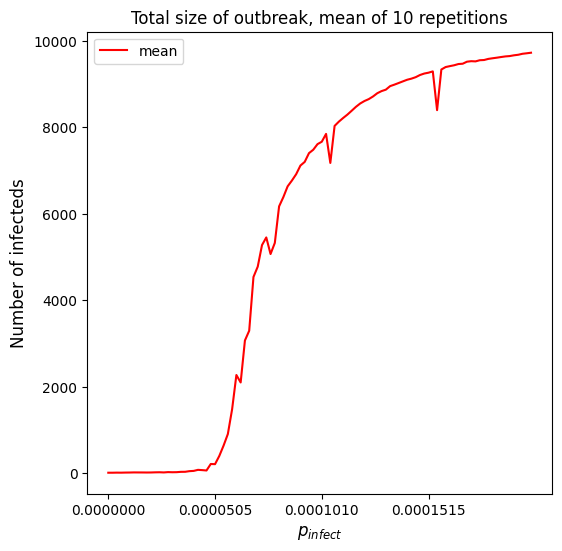

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the mean sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sir_er_verylow_reps")
pInfects = sorted(df[SIR.P_INFECT].unique())              # extract the experimental pInfect values
rs_mean = (df.groupby(SIR.P_INFECT))[SIR.REMOVED].mean()  # compute the mean of the repetitions at each pInfect
ax.plot(pInfects, rs_mean, 'r-', label="mean")

# fill in the title and axis labels
ax.set_title(f'Total size of outbreak, mean of {reps} repetitions')
ax.set_xlabel('$p_{infect}$')
ax.set_xticks(pInfects[::25])                  # only label some selected points
ax.set_ylabel('Number of infecteds')
ax.legend(loc='upper left')
plt.show()

That's showing us a smoother curve &ndash; but also showing some strange dips. What's causing this?

One way to explore this is to plot the raw data *and* the mean. In fact this is so important it's a vital step: you should *always* look at the raw data *as well as* any summary statistics, because radically different datasets will have the *same* means. So let's plot each raw data result, and their mean, on the same plot. And let's zoom-in even closer to what looks like the critical region.

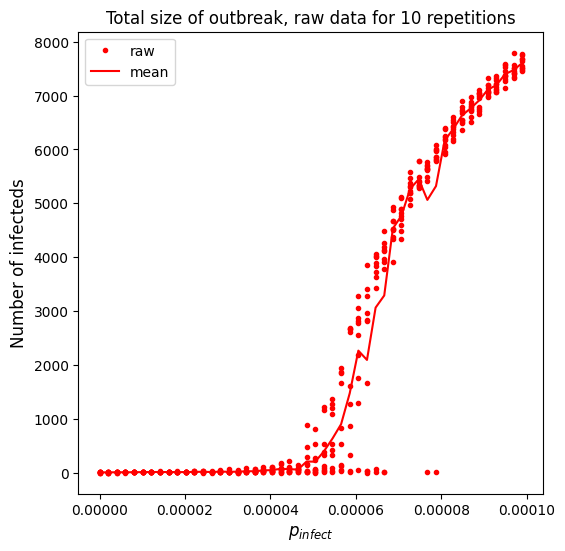

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sir_er_verylow_reps")
df_subset = df[df[SIR.P_INFECT] <= 0.0001]
ax.plot(df_subset[SIR.P_INFECT], df_subset[SIR.REMOVED], 'r.', label="raw")

# plot the mean
pInfects = sorted(df_subset[SIR.P_INFECT].unique())
rs_mean = (df_subset.groupby(SIR.P_INFECT))[SIR.REMOVED].mean()
ax.plot(pInfects, rs_mean, 'r-', label="mean")
                           
# fill in the title and axis labels
ax.set_title(f'Total size of outbreak, raw data for {reps} repetitions')
ax.set_xlabel('$p_{infect}$')
ax.set_ylabel('Number of infecteds')
ax.legend(loc='upper left')
plt.show()

Now we can see more detail. The places where the mean has been dragged down are the places where there are zeros in the raw data &ndash; in other words, where the outbreak of one of the simulations we did *just happened* to die out, while others with the *same* infectivity generated an outbreak. The simulations that *did* actually generate outbreaks seem to cluster quite closely round the mean, but the *outliers* drag it down.

Should we delete the outliers somehow? We could &ndash; but we probably shouldn't. It's true that they're not entirely representative, in the sense that they don't do the "expected" thing. But they're still data, properly collected, so we need to account for them. At the very least we need a reason for discarding them other than our convenience in creating cleaner plots.

Another way to view the data is to plot the variance &ndash; or, more properly, the *standard error* (also called the *standard deviation*), which is the square root of variance. Standard error takes the form of *error bars* bracketing the mean. The larger the error bars, the larger tha variance in the raw samples that gave rise to the mean.

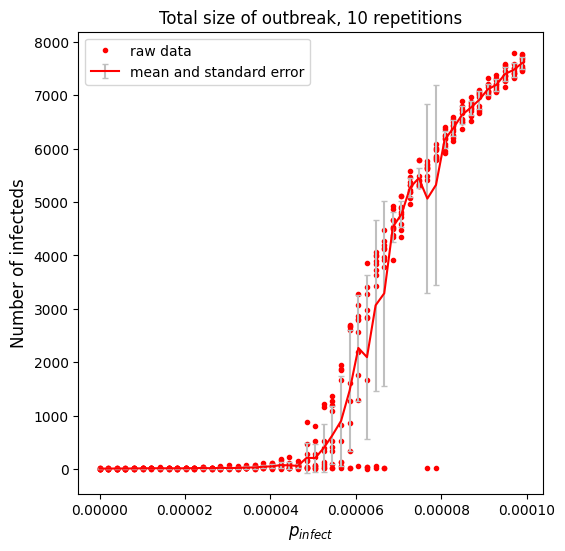

In [13]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the sizes of final outbreak sizes
df = nb.dataframe("sir_er_verylow_reps")
df_subset = df[df[SIR.P_INFECT] <= 0.0001]
ax.plot(df_subset[SIR.P_INFECT], df_subset[SIR.REMOVED], 'r.', label="raw data")

# plot mean and standard error bars
pInfects = sorted(df_subset[SIR.P_INFECT].unique())
rs_mean = (df_subset.groupby(SIR.P_INFECT))[SIR.REMOVED].mean()
rs_error = (df_subset.groupby(SIR.P_INFECT))[SIR.REMOVED].std()
ax.errorbar(pInfects, rs_mean, yerr=rs_error, fmt='r-', ecolor='0.75', capsize=2.0, label="mean and standard error")
                                
# fill in the title and axis labels
ax.set_title(f'Total size of outbreak, {reps} repetitions')
ax.set_xlabel('$p_{infect}$')
ax.set_ylabel('Number of infecteds')
ax.legend(loc='upper left')
plt.show()

I also plotted the raw data, so we can also see that the variance is being enormously increased by those outlier values.

Another way to visualise variance is to replace the error bars with a shaded error interval. This shows the expected value (the mean) and the expected range of deviations (the interval) around each sample.

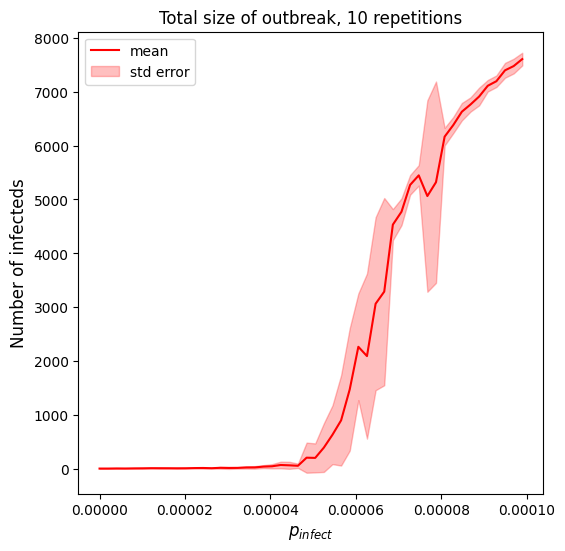

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the mean
df = nb.dataframe("sir_er_verylow_reps")
df_subset = df[df[SIR.P_INFECT] <= 0.0001]
pInfects = sorted(df_subset[SIR.P_INFECT].unique())
rs_mean = list((df_subset.groupby(SIR.P_INFECT))[SIR.REMOVED].mean())
ax.plot(pInfects, rs_mean, 'r-', label="mean")

# compute the shaded area for standard error
rs_error = list((df_subset.groupby(SIR.P_INFECT))[SIR.REMOVED].std())
hi = [ rs_mean[i] + rs_error[i] for i in range(len(rs_mean)) ]
lo = [ rs_mean[i] - rs_error[i] for i in range(len(rs_mean)) ]
ax.fill_between(pInfects, lo, hi, color='r', alpha=0.25, label="std error")

# fill in the title and axis labels
ax.set_title(f'Total size of outbreak, {reps} repetitions')
ax.set_xlabel('$p_{infect}$')
ax.set_ylabel('Number of infecteds')
ax.legend(loc='upper left')
plt.show()

You can see quite clearly from this plot where the variance is occurring: within the critical region around the epidemic threshold. To the left of the threshold there's essentially no variance at all: all experiments cluster around their means. In the narrow band of the phase transition, though, there can be significant variance as the value depends on stochastic variations in the process, and/or on exactly how thse fluctuations interact with the parts of the network they appear on. In fact there's quite a lot of "variance of the variance" (or *skewness*) that might be interesting to explore.

All these plots are simply ways of handling the effects of processes being stochastic. Because we've done lots of simulations, we have variations between individual experiments, and its important that we track these carefully. The raw data should always be the starting point. After that all the statistical techniques you know can potentially be used to analyse the simulation results. Mean and standard error are very commonly encountered in network science.

## Reducing variance

It's natural to ask: can variance be reduced, to get a more "certain" view of the mean? Yes, with more repetitions. The idea is that, if we do lots of simulations at each value of $p_{infect}$, we will get more "expected" values from the distribution of possible results: that's what "expected value" means, after all. This in turn means that outliers &ndash; which will still happen, of course ndash; will be less as a proportion of the samples we've taken,.and this will reduce the variance we observe.

The goal is to show that a process converges to its mean "almost always", meaning that variance is negligible. In fact, in the literature, you often don't see error bars plotted &ndash; because the authors have done so many simulations that the error bars are smaller than the line plotting the mean!

It's important not to be deceived by this, though. *Outliers still occur*. They're not impossible, just very unlikely.